In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-disease-prediction-dataquest/heart_test.csv
/kaggle/input/heart-disease-prediction-dataquest/sample_submission.csv
/kaggle/input/heart-disease-prediction-dataquest/heart_train.csv


In [2]:
train_data = pd.read_csv('/kaggle/input/heart-disease-prediction-dataquest/heart_train.csv')
test_data = pd.read_csv('/kaggle/input/heart-disease-prediction-dataquest/heart_test.csv')

In [3]:
train_data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,63,M,ATA,139,217,1,ST,128,Y,1.2,Flat,1
1,55,M,ATA,110,214,1,ST,180,N,0.4,Up,0
2,59,F,ASY,130,338,1,ST,130,Y,1.5,Flat,1
3,47,M,ASY,160,0,0,Normal,124,Y,0.0,Flat,1
4,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
...,...,...,...,...,...,...,...,...,...,...,...,...
729,51,M,NAP,135,160,0,Normal,150,N,2.0,Flat,1
730,46,M,NAP,120,230,0,Normal,150,N,0.0,Up,0
731,59,M,ASY,122,233,0,Normal,117,Y,1.3,Down,1
732,61,M,ASY,125,292,0,ST,115,Y,0.0,Up,0


In [4]:
test_data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,46,M,ASY,115,0,0,Normal,113,Y,1.5,Flat
1,58,M,NAP,132,224,0,LVH,173,N,3.2,Up
2,60,M,ASY,125,258,0,LVH,141,Y,2.8,Flat
3,49,M,NAP,120,188,0,Normal,139,N,2.0,Flat
4,39,F,NAP,138,220,0,Normal,152,N,0.0,Flat
...,...,...,...,...,...,...,...,...,...,...,...
179,45,M,ATA,140,224,1,Normal,122,N,0.0,Up
180,56,M,ASY,125,249,1,LVH,144,Y,1.2,Flat
181,49,M,TA,130,0,0,ST,145,N,3.0,Flat
182,59,M,ASY,110,239,0,LVH,142,Y,1.2,Flat


## Data Exploration

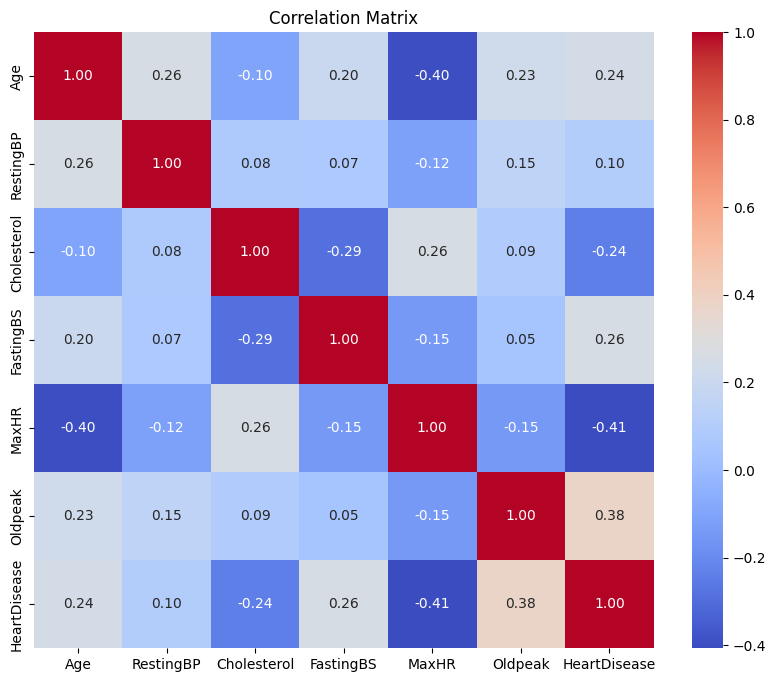

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns

corr_matrix = train_data[numerical_cols.tolist()].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

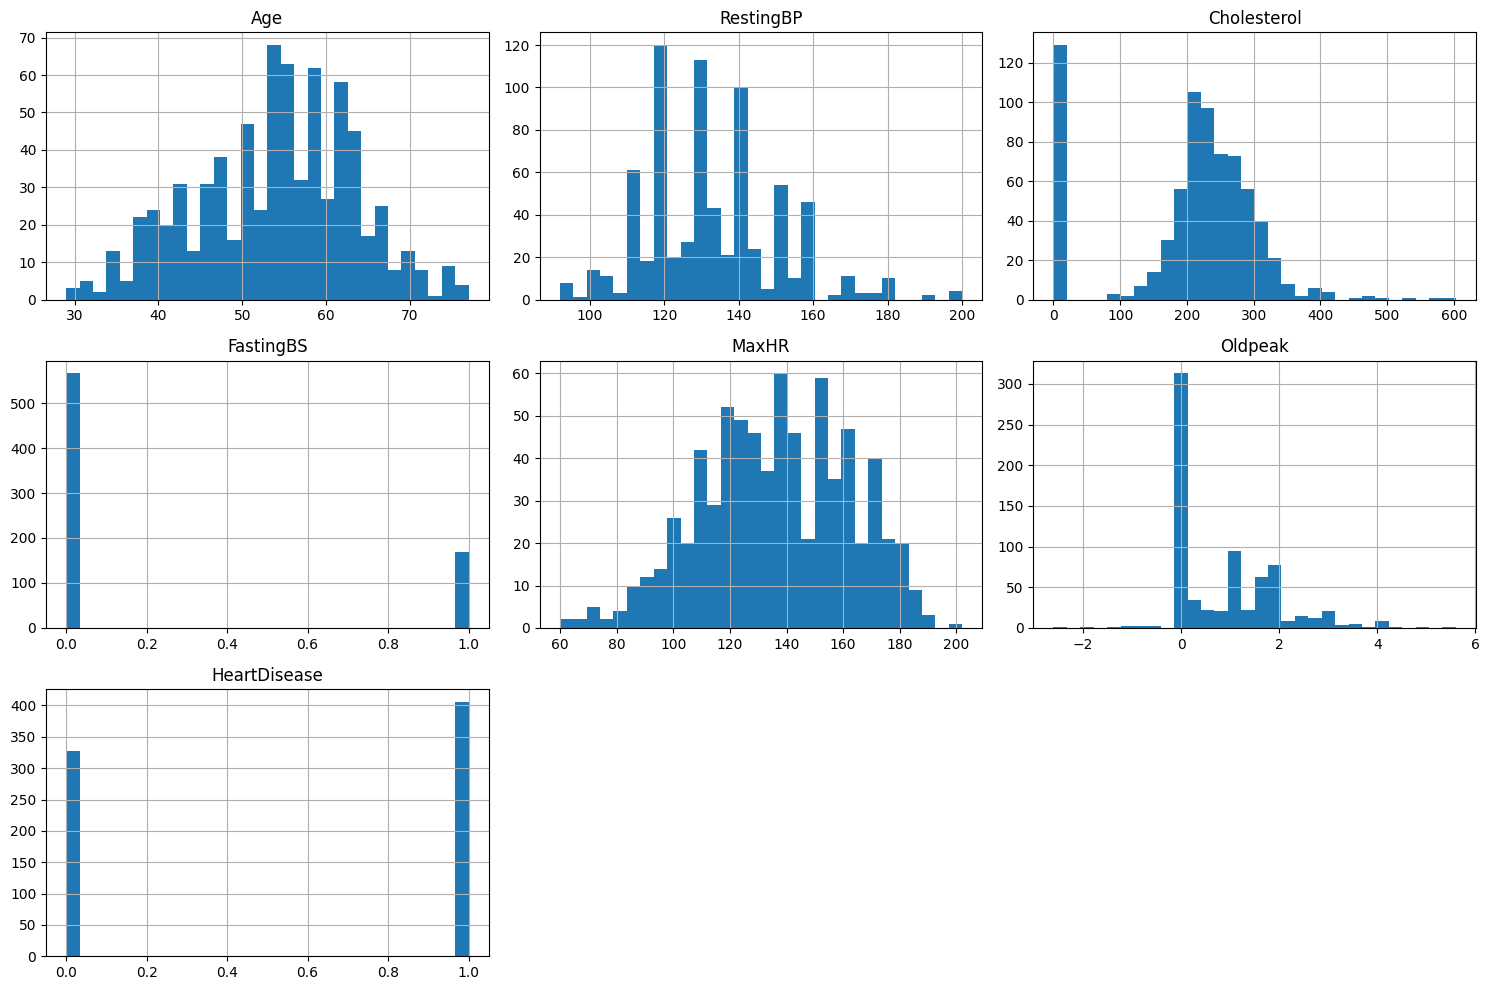

In [6]:
num_feats = train_data.select_dtypes(include=['int64', 'float64']).columns

train_data[num_feats].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

Lots of cholestrol values marked as zero, could indicate that they were simply not entered. This could be potentially misleading for the model. A good idea could be to assign the mean cholesterol level to eacn entry with a value of zero based on the age group: (>=40, 41-50, 51-60, 61-70, >=71) 

In [7]:
train_data['Cholesterol'].replace(0, np.nan, inplace=True)

bins = [0, 40, 50, 60, 70, np.inf]
labels = ['<=40', '41-50', '51-60', '61-70', '>=71']
train_data['AgeGroup'] = pd.cut(train_data['Age'], bins=bins, labels=labels)

cholesterol_means = train_data.groupby('AgeGroup')['Cholesterol'].transform('mean')

train_data['Cholesterol'] = train_data['Cholesterol'].fillna(cholesterol_means)

/tmp/ipykernel_13/1574908873.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Cholesterol'].replace(0, np.nan, inplace=True)
/tmp/ipykernel_13/1574908873.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cholesterol_means = train_data.groupby('AgeGroup')['Cholesterol'].transform('mean')


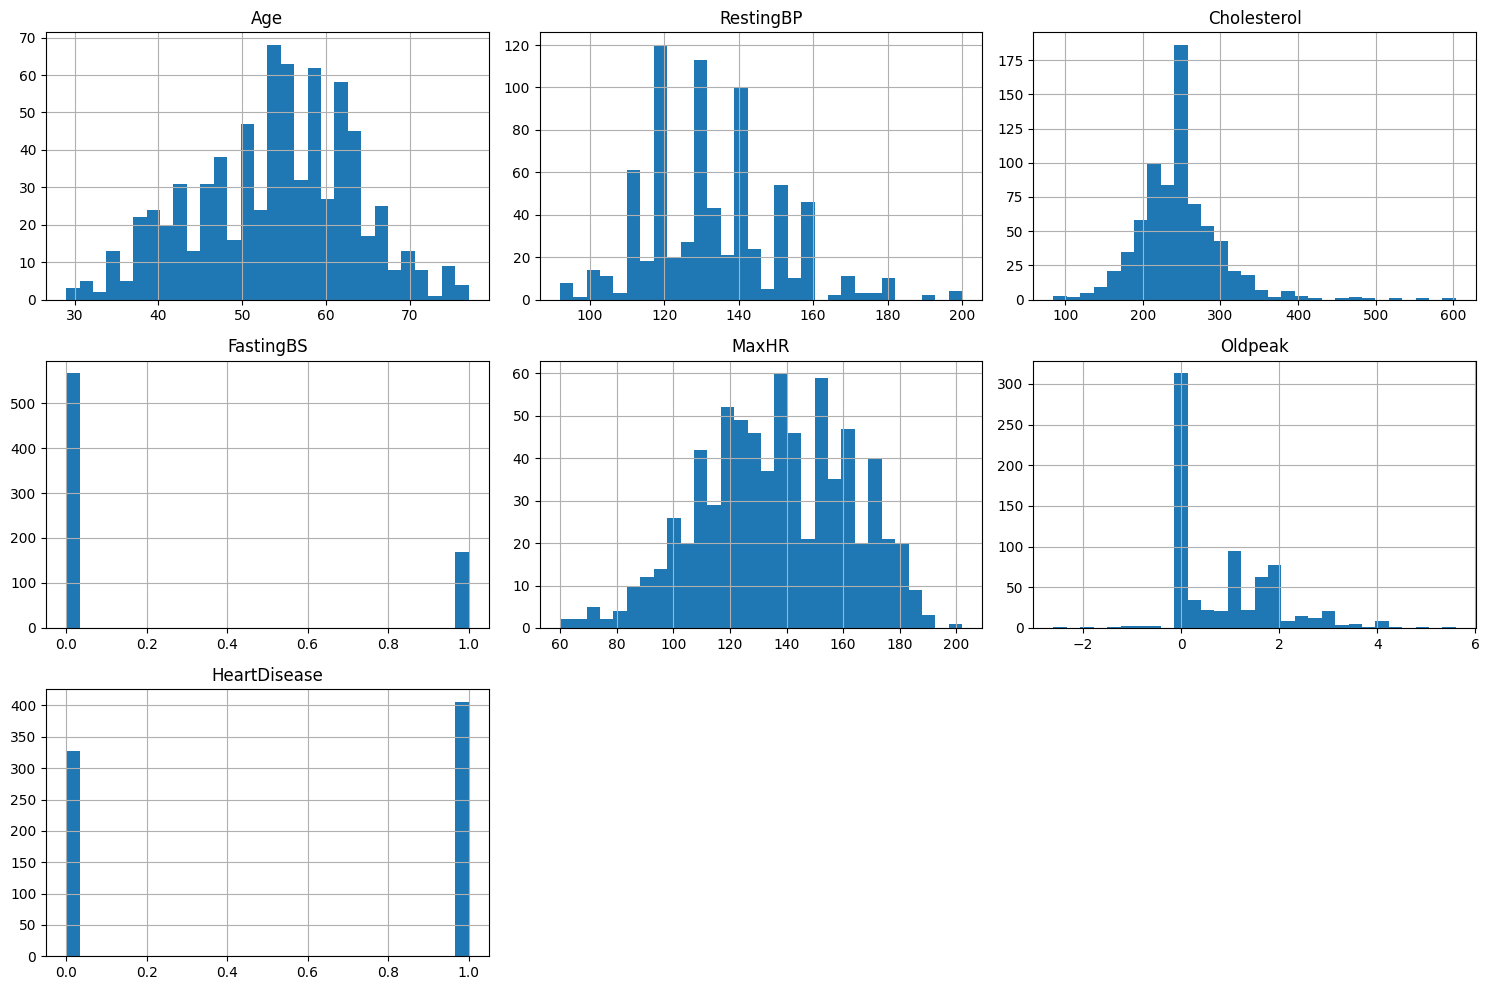

In [8]:
num_feats = train_data.select_dtypes(include=['int64', 'float64']).columns

train_data[num_feats].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

From what I have found it is highly irregular for Oldpeak values to be negative, so I will cap them at 0 for now.

In [9]:
train_data['Oldpeak'] = train_data['Oldpeak'].clip(lower=0)

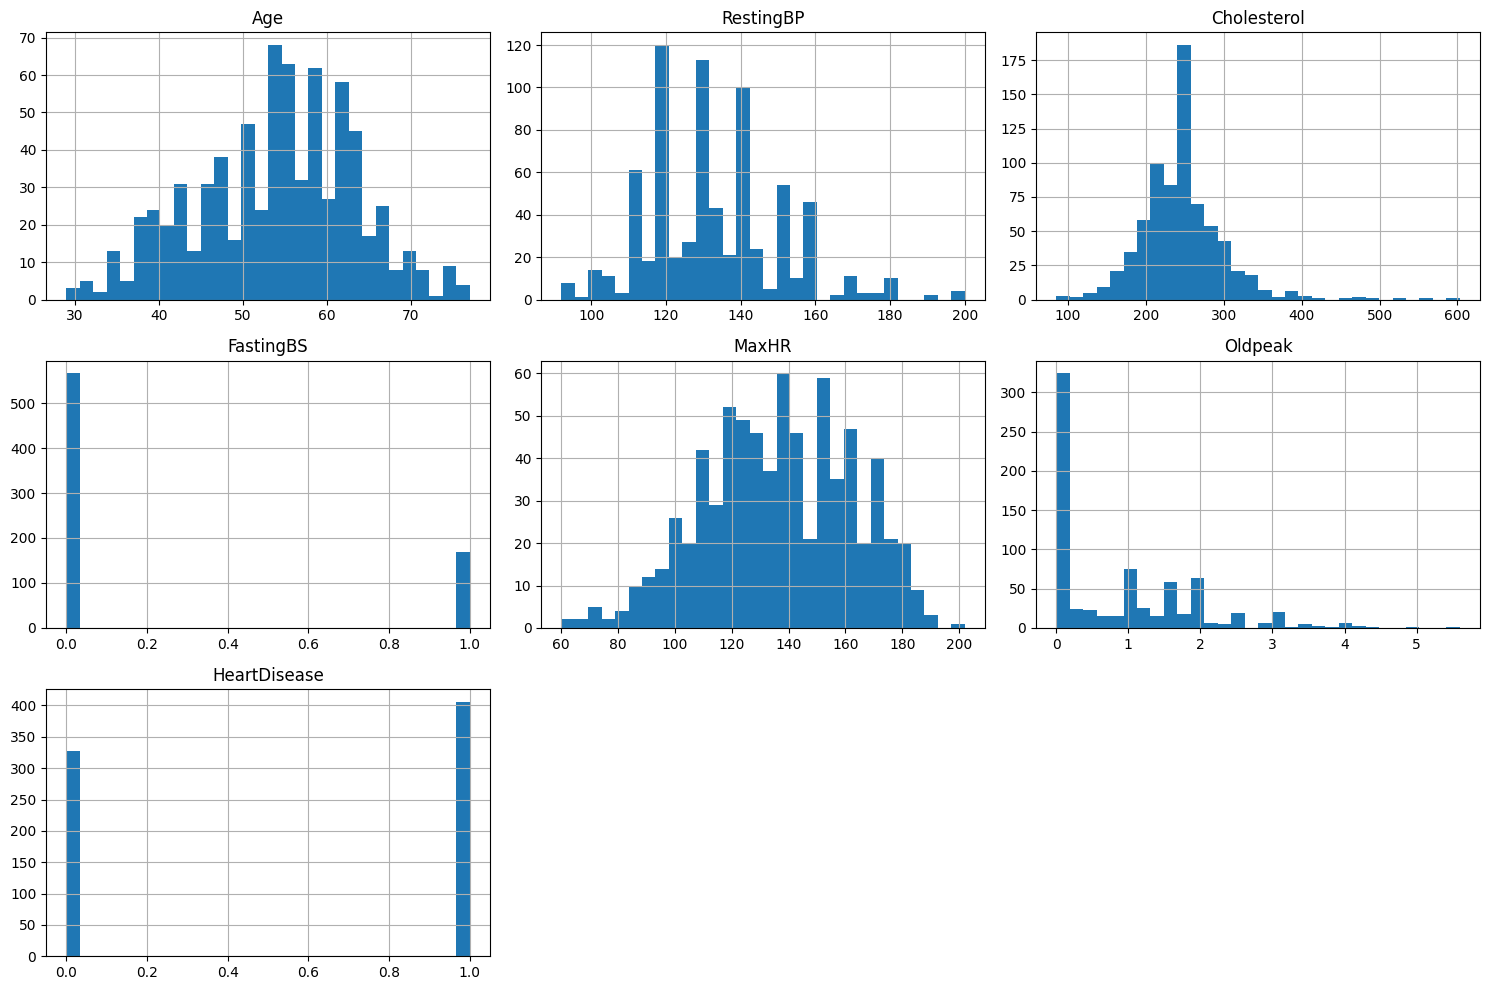

In [10]:
num_feats = train_data.select_dtypes(include=['int64', 'float64']).columns

train_data[num_feats].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

Now I will try to find potential outliers by first looking at the Box Plot of each numerical feature

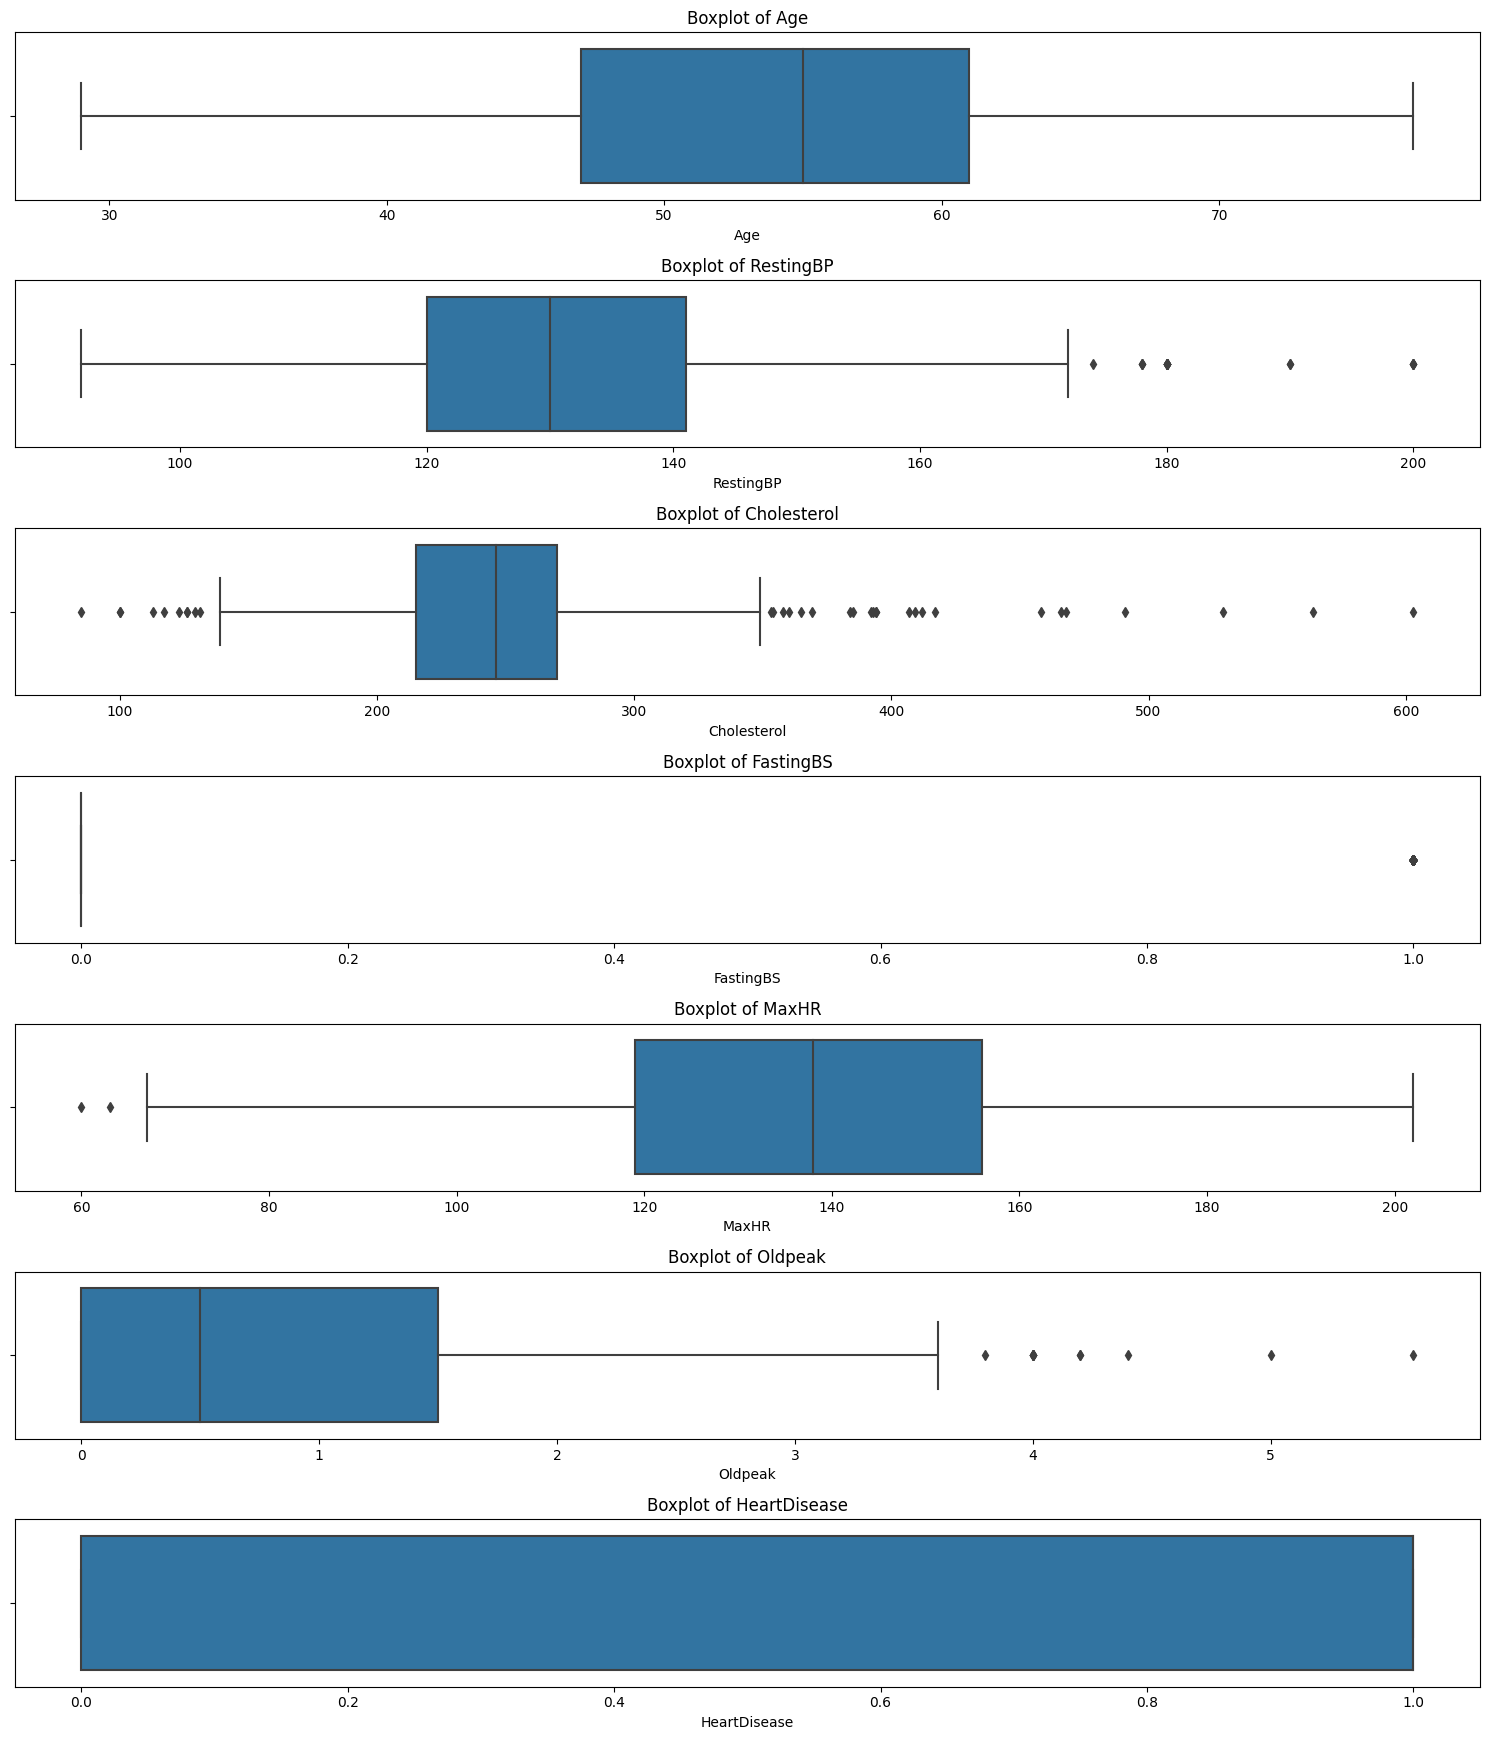

In [11]:
plt.figure(figsize=(15, len(num_feats) * 2.5))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 1, i)
    sns.boxplot(x=train_data[col])
    plt.title(f'Boxplot of {col}', fontsize=12)
    plt.tight_layout()

plt.show()

Removing outliers for such a small dataset can be problematic since there is already a small amount of data for the ML models. I will cap (Winsorize) the values instead. Contrary to the chart, I think FastingBS does not have outliers

In [12]:
for col in ['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']:
    lower_cap = train_data[col].quantile(0.01)
    upper_cap = train_data[col].quantile(0.99)

    train_data[col] = train_data[col].clip(lower=lower_cap, upper=upper_cap)

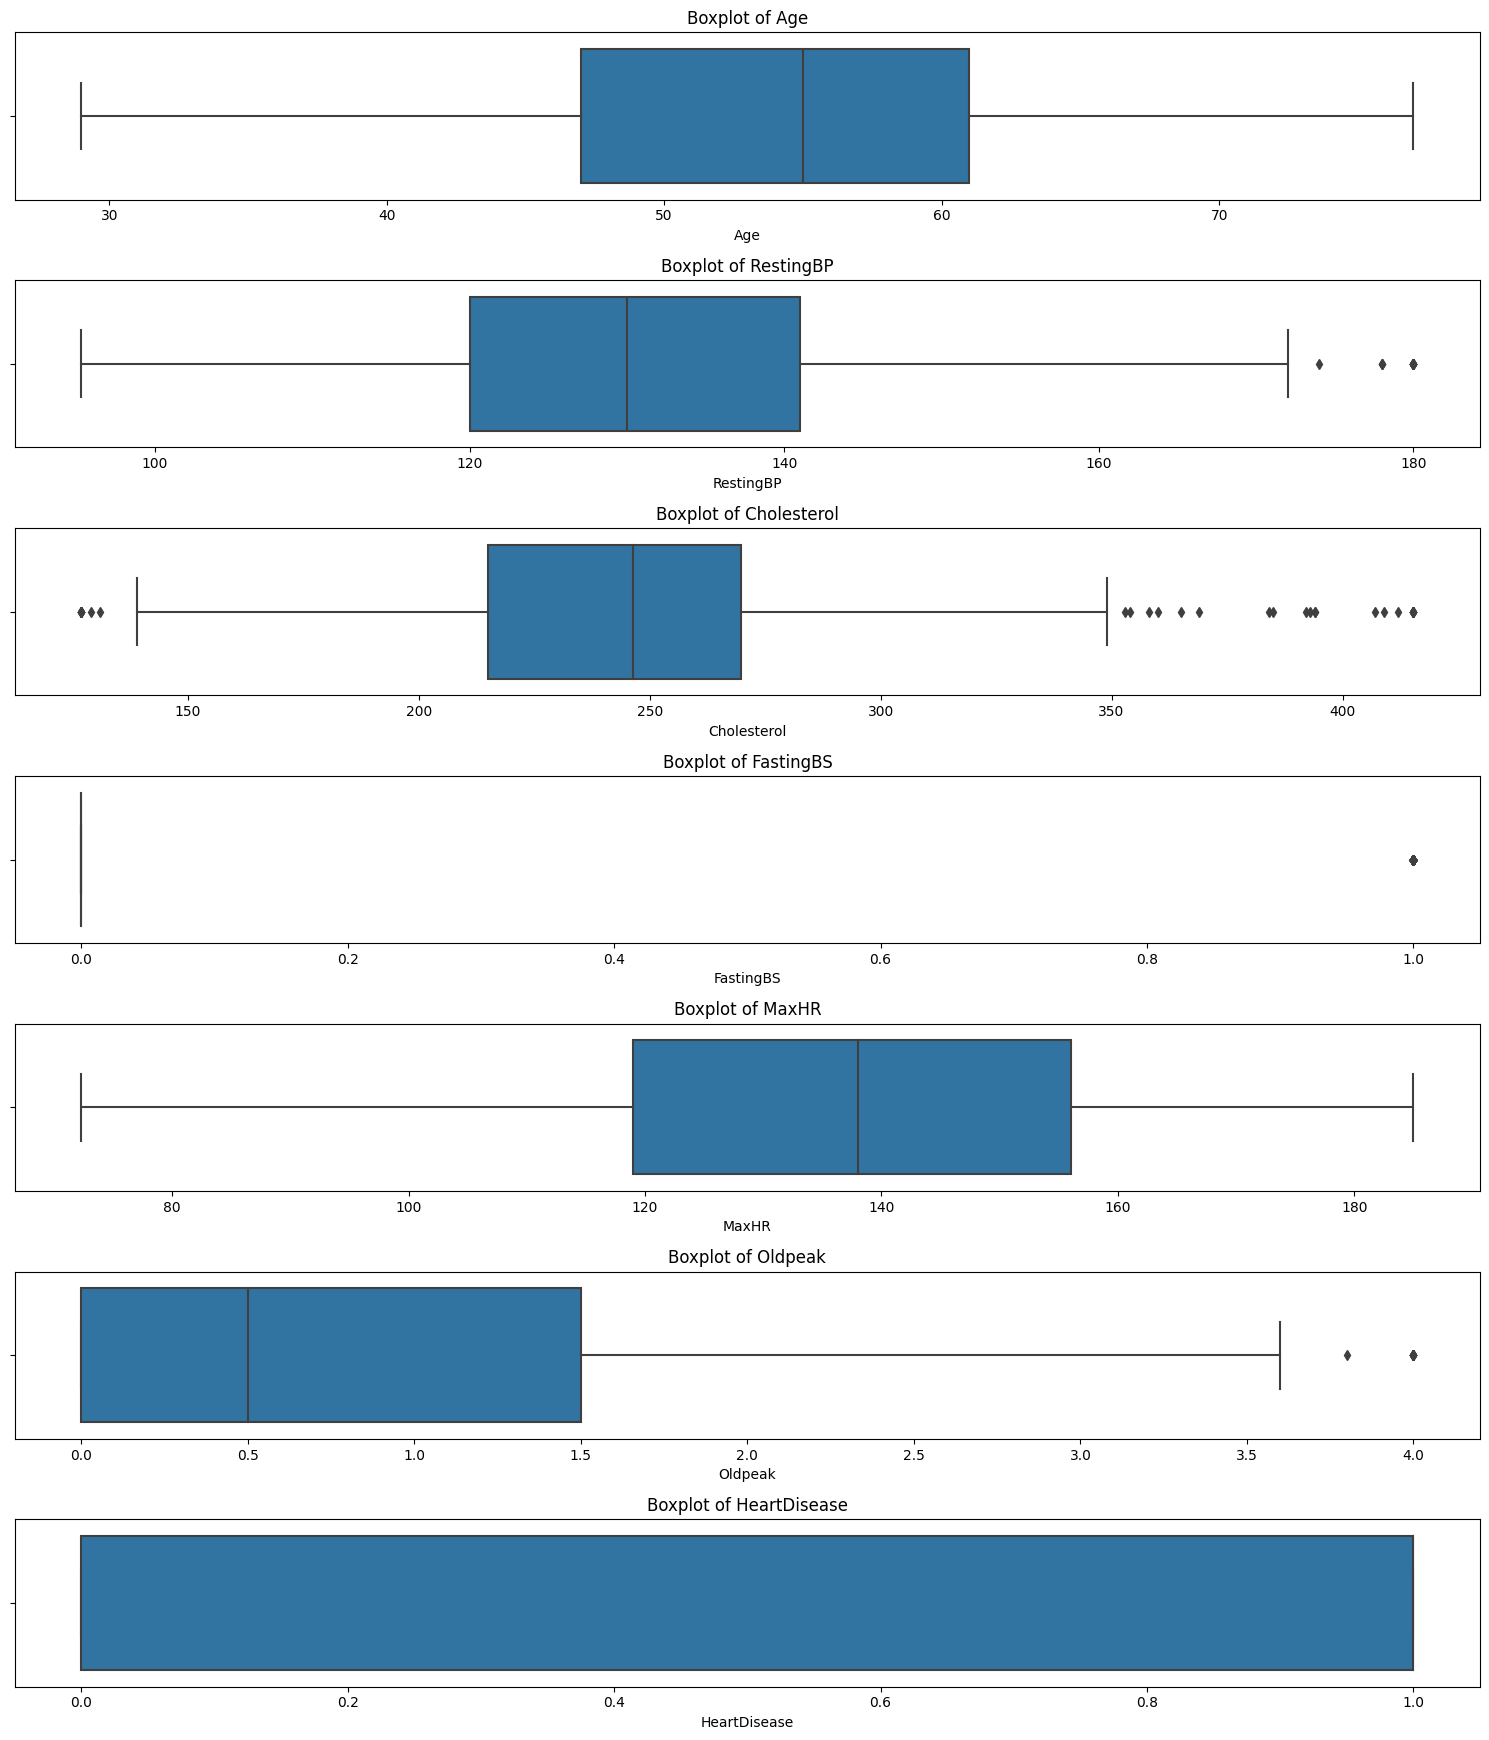

In [13]:
plt.figure(figsize=(15, len(num_feats) * 2.5))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 1, i)
    sns.boxplot(x=train_data[col])
    plt.title(f'Boxplot of {col}', fontsize=12)
    plt.tight_layout()

plt.show()

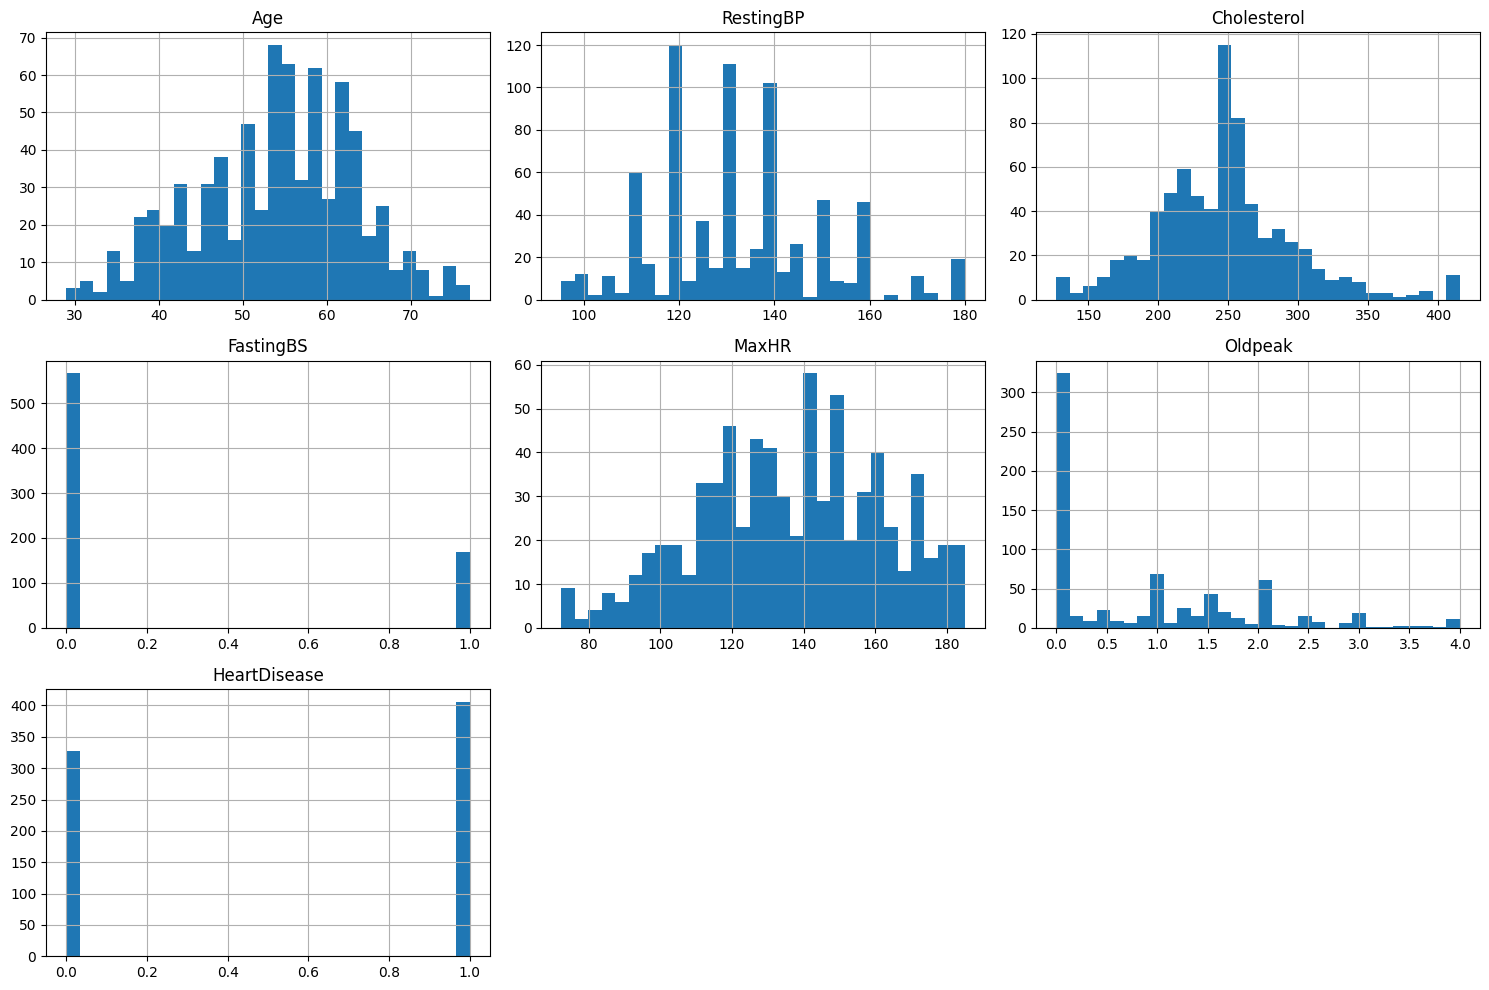

In [14]:
num_feats = train_data.select_dtypes(include=['int64', 'float64']).columns

train_data[num_feats].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

## Data Cleaning and Preparation

In [15]:
train_data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
AgeGroup          0
dtype: int64

In [16]:
cat_feats = train_data.select_dtypes(include='object').columns
train_data[cat_feats].nunique().sort_values()

Sex               2
ExerciseAngina    2
RestingECG        3
ST_Slope          3
ChestPainType     4
dtype: int64

In [17]:
cat_feats = list(cat_feats)
cat_feats.append('AgeGroup')
dummies = pd.get_dummies(train_data[cat_feats], drop_first=False).astype(int)
train_data_enc = train_data.drop(columns=cat_feats).join(dummies)

In [18]:
train_data_enc.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,AgeGroup_<=40,AgeGroup_41-50,AgeGroup_51-60,AgeGroup_61-70,AgeGroup_>=71
0,63,139.0,217.0,1,128.0,1.2,1,0,1,0,...,0,1,0,1,0,0,0,0,1,0
1,55,110.0,214.0,1,180.0,0.4,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0
2,59,130.0,338.0,1,130.0,1.5,1,1,0,1,...,0,1,0,1,0,0,0,1,0,0
3,47,160.0,243.0,0,124.0,0.0,1,0,1,1,...,0,1,0,1,0,0,1,0,0,0
4,50,145.0,243.0,1,139.0,0.7,1,0,1,1,...,0,1,0,1,0,0,1,0,0,0


## Model Selection

In [19]:
from sklearn.model_selection import train_test_split

X = train_data_enc.drop('HeartDisease', axis=1)
y = train_data_enc['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
X_train = train_data_enc.drop('HeartDisease', axis=1)
y_train =  train_data_enc['HeartDisease']

In [21]:
import re

X_train.columns = [re.sub(r'[<>\[\]"\']', '', str(col)) for col in X_train.columns]

Performing cross-validation to see which of the three models would work best:

In [22]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

svm_pipeline = make_pipeline(StandardScaler(), SVC(probability=True, kernel='rbf', random_state=42))
logreg_l2_pipeline = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42))
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

models = {
    'SVM': svm_pipeline,
    'Logistic Regression': logreg_l2_pipeline,
    'XGBoost': xgb_model
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')  # or 'accuracy'
    print(f"{name} - Mean AUC: {scores.mean():.4f}, Std: {scores.std():.4f}")

SVM - Mean AUC: 0.9146, Std: 0.0294
Logistic Regression - Mean AUC: 0.9144, Std: 0.0344
XGBoost - Mean AUC: 0.9143, Std: 0.0164


All three models seem to be closely accurate, therefore I think it's a safe bet to go for majority voting amongst the three models.

UPDATE: After several submission attempts I found that in fact the Logistic Regression model with Ridge Regularization works the best, and the other 2 models drag it down, which is why I ended up abandoning the voting and simply sticking with Logistic Regression

In [23]:
logreg_l2 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
logreg_l2.fit(X_train, y_train)

LogisticRegression(max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')

## Preparing the Test Data

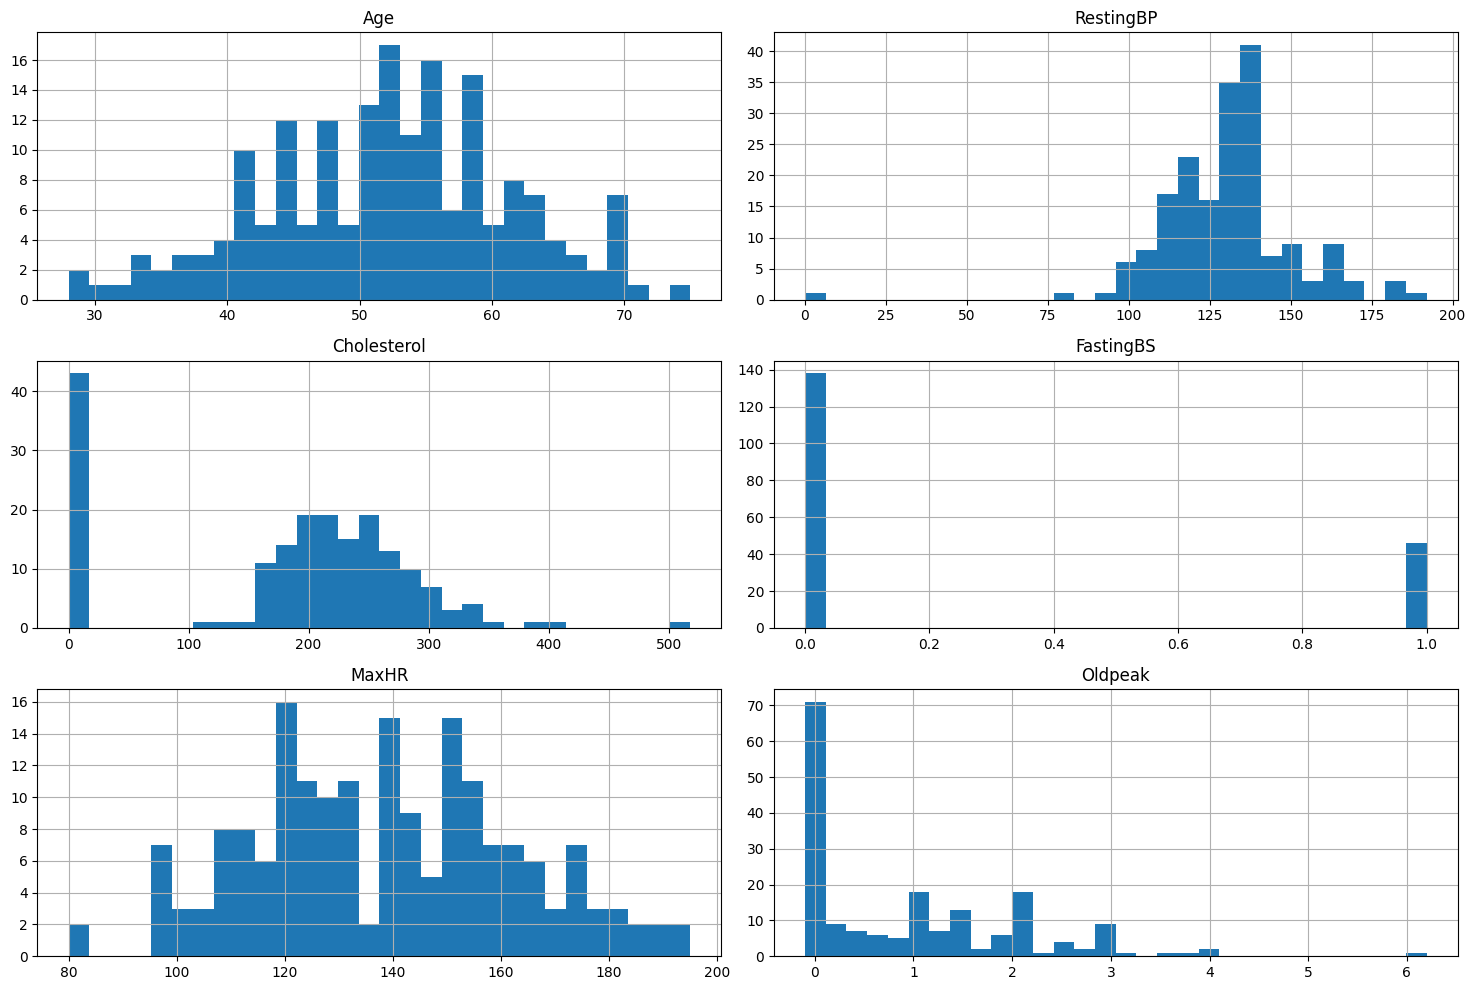

In [24]:
num_feats = test_data.select_dtypes(include=['int64', 'float64']).columns

test_data[num_feats].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

Since our test data also has a very large number of entries with 0, we would have to assume that they are NaN values, and deal with them they way they were dealt with in the training data, ie, by assigning them to the mean within each age category.

In [25]:
test_data['Cholesterol'].replace(0, np.nan, inplace=True)

bins = [0, 40, 50, 60, 70, np.inf]
labels = ['<=40', '41-50', '51-60', '61-70', '>=71']
test_data['AgeGroup'] = pd.cut(test_data['Age'], bins=bins, labels=labels)

cholesterol_means = test_data.groupby('AgeGroup')['Cholesterol'].transform('mean')

test_data['Cholesterol'] = test_data['Cholesterol'].fillna(cholesterol_means)

/tmp/ipykernel_13/770945393.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['Cholesterol'].replace(0, np.nan, inplace=True)
/tmp/ipykernel_13/770945393.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cholesterol_means = test_data.groupby('AgeGroup')['Cholesterol'].transform('mean')


In [26]:
test_data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
AgeGroup          0
dtype: int64

In [27]:
cat_feats = test_data.select_dtypes(include='object').columns
test_data[cat_feats].nunique().sort_values()

Sex               2
ExerciseAngina    2
RestingECG        3
ST_Slope          3
ChestPainType     4
dtype: int64

In [28]:
test_data_enc = pd.get_dummies(test_data, columns=cat_feats)

## Running the Model on Test Data

In [29]:
X_test = test_data_enc

for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = 0

X_test = X_test[X_train.columns]
y_pred = logreg_l2.predict(X_test)

In [30]:
submission = pd.DataFrame({
    "id": X_test.index,
    "HeartDisease" : y_pred
})

submission.to_csv("submission.csv", index=False)

The model scored 0.94565 in terms of accuracy of the predictions